# Hypothesis Testing

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/master/11_resampling.ipynb) or
[click here to download it](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/11_resampling.ipynb).

Intro

## Peanut Allergies



In [1]:
n_control = 314
n_treatment = 314

In [2]:
k_control = 54
k_treatment = 10

In [3]:
risk_control = k_control / n_control * 100
risk_control

17.197452229299362

In [4]:
risk_treatment = k_treatment / n_treatment * 100
risk_treatment

3.1847133757961785

In [53]:
relative_risk_actual = risk_treatment / risk_control
relative_risk_actual

0.1851851851851852

In [54]:
n_total = n_control + n_treatment
k_total = k_control + k_treatment
p_null = k_total / n_total
p_null

0.10191082802547771

In [55]:
import numpy as np

def simulate_group(n, p):
    xs = np.random.random(size=n)
    k = np.sum(xs < p)
    return k / n * 100

In [56]:
np.random.seed(17)

In [57]:
t1 = [simulate_group(n_treatment, p_null)
      for i in range(1000)]

In [58]:
t2 = [simulate_group(n_control, p_null)
      for i in range(1000)]

In [60]:
relative_risks = np.array(t2) / t1

The result is a list of estimated risks that shows how much we expect the results of the trial to vary due to randomness.
We can use a KDE plot to visualize the distribution of these estimates

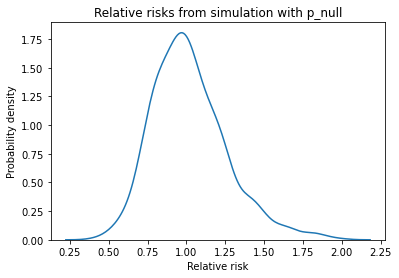

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(relative_risks)

plt.xlabel('Relative risk')
plt.ylabel('Probability density')
plt.title('Relative risks from simulation with p_null');

The mean of this distribution is about 5.3, which is close to the observed risk, as we should expect.

In [62]:
p_value = (relative_risks <= relative_risk_actual).mean()
p_value

0.0

This result is called a 

## Are first babies more likely to be late?

In [63]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/nsfg.hdf')

In [64]:
import pandas as pd

nsfg = pd.read_hdf('nsfg.hdf', 'nsfg')

In [65]:
live = (nsfg['OUTCOME'] == 1)
live.sum()

6693

In [66]:
fullterm = (nsfg['PRGLNGTH'] >= 37) & (nsfg['PRGLNGTH'] < 48)

In [67]:
first = live & fullterm & (nsfg['BIRTHORD'] == 1)
first.sum()

2724

In [68]:
other = live & fullterm & (nsfg['BIRTHORD'] > 1)
other.sum()

3115

In [69]:
length_first = nsfg.loc[first, 'PRGLNGTH']
length_first.mean()

39.39647577092511

In [70]:
length_other = nsfg.loc[other, 'PRGLNGTH']
length_other.mean()

39.19775280898877

In [71]:
diff_actual = length_first.mean() - length_other.mean()
diff_actual, diff_actual * 7 * 24

(0.19872296193634043, 33.38545760530519)

In [72]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [73]:
from empiricaldist import Cdf

cdf_first = Cdf.from_seq(length_first)
cdf_other = Cdf.from_seq(length_other)

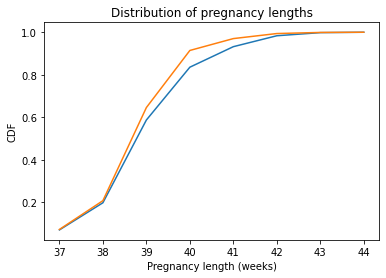

In [74]:
cdf_first.plot(label='first babies')
cdf_other.plot(label='others')

plt.xlabel('Pregnancy length (weeks)')
plt.ylabel('CDF')
plt.title('Distribution of pregnancy lengths');

In [75]:
length = nsfg.loc[live&fullterm, 'PRGLNGTH']
mean = length.mean()
std = length.std()
mean, std

(39.29046069532454, 1.1864094701037655)

In [76]:
def simulate_sample_mean(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.mean()

In [77]:
n_first = len(length_first)
n_first

2724

In [78]:
n_other = len(length_other)
n_other

3115

If we run it 1000 times, it simulates the sampling and measurement process and returns a list of results from 1000 simulated experiments.

In [79]:
t_first = [simulate_sample_mean(n_first, mean, std)
      for i in range(1000)]

In [80]:
t_other = [simulate_sample_mean(n_other, mean, std)
      for i in range(1000)]

In [81]:
diffs = np.array(t_first) - t_other

We can use a KDE plot to visualize the distribution of these values.

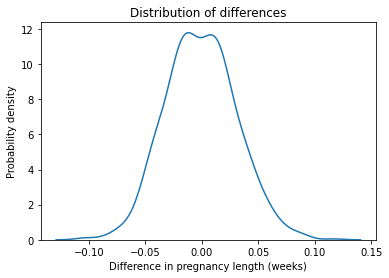

In [82]:
sns.kdeplot(diffs)

plt.xlabel('Difference in pregnancy length (weeks)')
plt.ylabel('Probability density')
plt.title('Distribution of differences');

In [100]:
p_value = (np.abs(diffs) > diff_actual).mean()
p_value

0.0

## The Hypothesis Testing Framework

The examples we've done so far fit into the framework shown in this diagram:

![](https://github.com/AllenDowney/ElementsOfDataScience/raw/master/figs/hypothesis_testing.png)

I emphasize the role of the model in this framework because for a given experiment there might be several possible models, each including some elements of the real world and ignoring others.

For example, our model of the vaccine experiment assumes that everyone in each group has the same risk, but that's probably not true.
Here's another version of `simulate_group` that includes variation in risk within each group.

In [101]:
def simulate_two_groups(data1, data2):
    n, m = len(data1), len(data2)
    data = np.append(data1, data2)
    np.random.shuffle(data)
    group1 = data[:n]
    group2 = data[n:]
    assert len(group2) == m
    return group1.mean() - group2.mean()

In [102]:
simulate_two_groups(length_first, length_other)

0.01361478611144662

**Exercise:** Using this function to run 1000 simulations of the treatment group.  Compute the mean of the results and confirm that it is close to the observed `risk_treatment`.  To quantify the spread of the sampling distribution, compute the standard error.  How does it compare to the standard error we computed with the original model, where everyone in the group has the same risk? 

In [103]:
# Solution

diffs2 = [simulate_two_groups(length_first, length_other)
          for i in range(1000)]

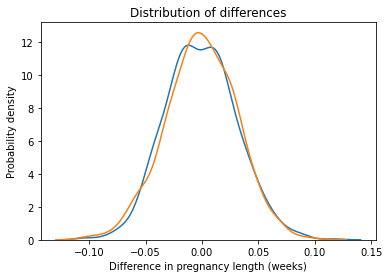

In [104]:
# Solution

sns.kdeplot(diffs)
sns.kdeplot(diffs2)

plt.xlabel('Difference in pregnancy length (weeks)')
plt.ylabel('Probability density')
plt.title('Distribution of differences');

In [99]:
p_value = (np.abs(diffs2) > diff_actual).mean()
p_value

0.0

**Exercise:** The following is a version of `simulate_trial` that uses `simulate_variable_group`, from the previous exercise, to simulate the vaccine trial using the modified model, with variation in risk within the groups.

Use this function to simulate 1000 trials.  Compute the mean of the sampling distribution and confirm that it is close to the observed `efficacy`.  Compute the standard error and compare it to the standard error we computed for the original model

In [36]:
def simulate_variable_trial(n1, p1, n2, p2):
    risk1 = simulate_variable_group(n1, p1)
    risk2 = simulate_variable_group(n2, p2)
    efficacy = 1 - risk2 / risk1
    return efficacy

In [37]:
# Solution

p1 = k_control / n_control
p2 = k_treatment / n_treatment
simulate_variable_trial(n_control, p1, n_treatment, p2)

0.7060783539089954

In [38]:
# Solution

t5 = [simulate_variable_trial(n_control, p1, n_treatment, p2)
      for i in range(1000)]

In [39]:
# Solution

np.mean(t5), efficacy

(0.6718099644090157, 0.6708455902182797)

In [40]:
# Solution

# The standard error is a little smaller with the modified model

np.std(t5), np.std(t2)

(0.035858846807684176, 0.035068503707114076)

**Exercise:** One nice thing about the resampling framework is that it is easy to compute the sampling distribution for other statistics.

For example, suppose we want to estimate the coefficient of variation (standard deviation as a fraction of the mean) for adult male height.  Here's how we can compute it.

In [41]:
cv = std_height / mean_height
cv

0.04745762711864407

In this example, the standard deviation is about 5% of the mean. 
The following is a version of `simulate_sample` that generates a random sample of heights and returns the coefficient of variation, rather than the mean. 

In [42]:
def simulate_sample_cv(n, mu, sigma):
    sample = np.random.normal(mu, sigma, size=n)
    return sample.std() / sample.mean()

Use this function to simulate 1000 samples with size `n=103`, using `mean_height` for `mu` and `std_height` for `sigma`.  Plot the sampling distribution of the coefficient of variation, and compute a 90% confidence interval.

In [43]:
# Solution

t6 = [simulate_sample_cv(n_height, mean_height, std_height)
      for i in range(1000)]

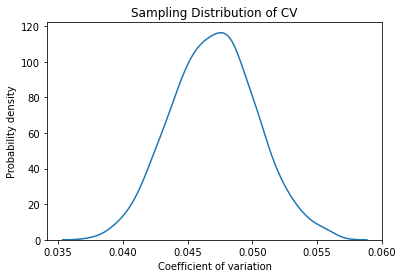

In [44]:
# Solution

sns.kdeplot(t6)

plt.xlabel('Coefficient of variation')
plt.ylabel('Probability density')
plt.title('Sampling Distribution of CV');

In [45]:
# Solution

np.percentile(t6, [5, 95])

array([0.04174409, 0.05249667])

## Gun Control

In Chapter 10 we used data from the General Social Survey, specifically a variable called `GUNLAW`, to describe support for a gun control law as a function of age, sex, and years of education.
Now let's come back to that dataset and see how the responses have changed over time.

The following cell reloads the data.

In [ ]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

In [46]:
download('https://github.com/AllenDowney/' +
         'ElementsOfDataScience/raw/master/data/gss_eda.hdf')

In [47]:
import pandas as pd

gss = pd.read_hdf('gss_eda.hdf', 'gss')

The column named `GUNLAW` records responses to the question "Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?"

The response code `1` means yes; `2` means no.  It will be easier to work with this variable if we recode it so `0` means no.

In [48]:
gss['GUNLAW'].replace(2, 0, inplace=True)
gss['GUNLAW'].value_counts()

1.0    32038
0.0     9975
Name: GUNLAW, dtype: int64

For each year of the survey, I would like to compute the number of respondents and the number who said they favor this law.
I'll use `groupby` to group the respondents by year of interview and `agg` to compute two aggregation functions, `sum` and `count`.

In [49]:
grouped = gss.groupby('YEAR')['GUNLAW']
agg = grouped.agg(['sum', 'count'])
agg.head()

,sum,count
YEAR,,
1972,1131.0,1562
1973,1099.0,1470
1974,1112.0,1459
1975,1096.0,1450
1976,1068.0,1472


The result is a `DataFrame` with two columns: `sum` is the number of respondents who said "yes"; `count` is the number of respondents who were asked the question.

In some years the question was not asked, so I'll use `drop` to remove those rows.

In [50]:
zero = (agg['count'] == 0)
labels = agg.index[zero]
agg.drop(labels, inplace=True)

In [51]:
assert (gss['GUNLAW'].value_counts().sum()
        == agg['count'].sum())

Now we can plot the percentage of respondents who favor gun control (at least for this wording of the question) during each year.

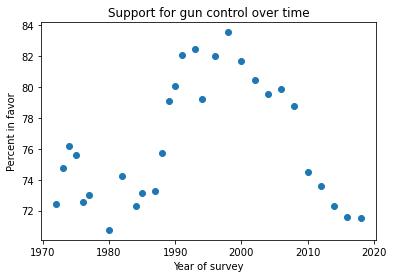

In [52]:
percent = agg['sum'] / agg['count'] * 100
percent.plot(style='o')

plt.xlabel('Year of survey')
plt.ylabel('Percent in favor')
plt.title('Support for gun control over time');

The results vary from year to year.  It is hard to tell how much of this variation is due to real changes in opinion, and how much is due to random sampling.
We can answer that question by computing confidence intervals for each of these data points.

**Exercise:** Write a loop that goes through the rows in `agg` and computes a confidence interval for each year.
You can use `itertuples` to iterate the rows, like this:

```
for year, k, n in agg.itertuples():
    print(year, k, n)
```

For each row, compute a 90% confidence interval and plot it as a vertical line.
Then plot the data points and label the axes.
The result should give you a sense of how much variation we expect to see from year to year due to random sampling.

You might want to use this version of `simulate_group`, which returns results as a percentage, rather than per 1000.

In [53]:
def simulate_group_percent(n, p):
    xs = np.random.random(size=n)
    k = np.sum(xs < p)
    return k / n * 100

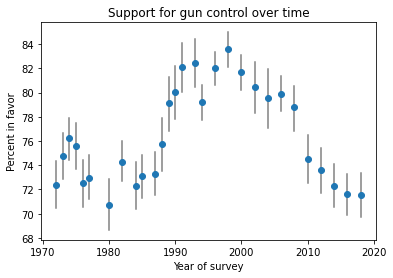

In [54]:
# Solution

for year, k, n in agg.itertuples():
    p = k / n
    t7 = [simulate_group_percent(n, p)
         for i in range(1000)]
    ci = np.percentile(t7, [5, 95])
    plt.plot([year, year], ci, 'gray')
    
percent.plot(style='o')

plt.xlabel('Year of survey')
plt.ylabel('Percent in favor')
plt.title('Support for gun control over time');